In [1]:
import pandas as pd
import numpy as np
import ast
from matplotlib import pyplot as plt
import sys
sys.path.append('../src/')
import data_layer


In [2]:
from tueplots import bundles
plt.rcParams.update(bundles.icml2022())

In [3]:
MIN_OCCURENCES=5

In [77]:
df_wiki = pd.read_csv("../dat/wiki/graph.csv")
df_llm = pd.read_json("../dat/llm/graph.json")
df_textbook = pd.read_json("../dat/textbooks/graph.json").iloc[:,[0,3]]
df_textbook.columns=['concept','dep_articles_textbook']
df_wiki.dep_articles = [[dep[1] for dep in ast.literal_eval(deps)] for deps in (df_wiki.dep_articles)]

In [78]:
_, _, df_count = data_layer.read_index_and_wiki_concepts(include_counts=True)

In [79]:
deps = pd.merge(df_wiki[['concept', 'dep_articles']], df_llm[['concept', 'dep_articles']], on="concept", suffixes=('_wiki', '_llm'))
deps = pd.merge(deps[['concept', 'dep_articles_wiki', 'dep_articles_llm']], df_textbook[['concept', 'dep_articles_textbook']], on="concept")
deps = pd.merge(deps, df_count, on="concept")

In [80]:
def get_number_common_concepts(concept, first, second):
    deps1 = set(first)
    deps2 = set(second)
    if len(deps1.intersection(deps2)):
        #print(f"{concept}: {first} vs {second}")
        pass
    return len(deps1.intersection(deps2))

deps['num_common_tb_wiki'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r.dep_articles_textbook, r.dep_articles_wiki), axis=1)
deps['num_common_tb_llm'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r.dep_articles_textbook, r.dep_articles_llm), axis=1)
deps['num_common_llm_wiki'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r.dep_articles_llm, r.dep_articles_wiki), axis=1)

In [81]:
filter = deps['count']>=MIN_OCCURENCES

In [20]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


fig = make_subplots(rows=1, cols=3,subplot_titles=("Textbooks and Wikipedia","Textbooks and T0pp", "T0pp and Wikipedia"))

trace0 = go.Histogram(x=deps.loc[filter,'num_common_tb_wiki'],texttemplate="%{y}",marker_color = "#BC602D",xbins_size=0.5)
trace1 = go.Histogram(x=deps.loc[filter,'num_common_tb_llm'],texttemplate="%{y}",marker_color = "#BC602D",xbins_size=0.5)
trace2 = go.Histogram(x=deps.loc[filter,'num_common_llm_wiki'],texttemplate="%{y}",marker_color = "#BC602D",xbins_size=0.5)

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 1, 3)

#fig.update_xaxes(title_text="# of common direct dependencies",  row=1, col=1)
fig.update_yaxes(title_text="Frequency", row=1, col=1)
fig.update_xaxes(title_text="# of common direct dependencies",  row=1, col=2)
#fig.update_xaxes(title_text="# of common direct dependencies",  row=1, col=3)

fig.update_layout({
"plot_bgcolor": "rgba(0, 0, 0, 0)",
"paper_bgcolor": "rgba(0, 0, 0, 0)"
}, showlegend=False)

fig.show()

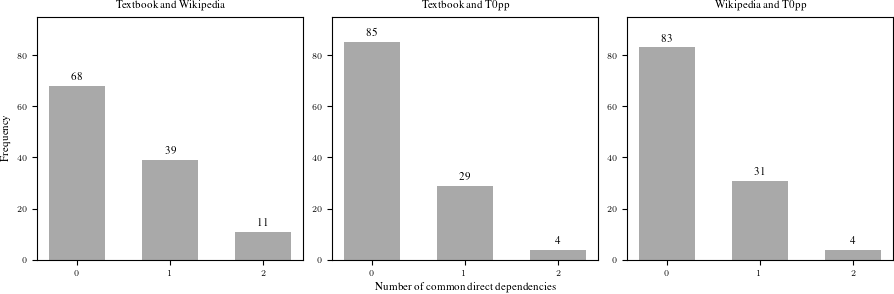

In [83]:
dep_freqs = deps.loc[filter]
dep_freqs = dep_freqs.iloc[:,-3:].apply(pd.Series.value_counts)

figs, ax = plt.subplots(1, 3, figsize=(9,3))

ax[0].set_title("Textbook and Wikipedia")
rects = ax[0].bar(dep_freqs.index,dep_freqs['num_common_tb_wiki'],width=0.6, color="darkgrey")
ax[0].bar_label(rects, padding=3)
ax[0].set_ylabel('Frequency')
ax[0].set_xticks(dep_freqs.index)
ax[0].set_ylim(0, 95)

ax[1].set_title("Textbook and T0pp")
rects = ax[1].bar(dep_freqs.index,dep_freqs['num_common_tb_llm'],width=0.6, color="darkgrey")
ax[1].bar_label(rects, padding=3)
ax[1].set_xticks(dep_freqs.index)
ax[1].set_ylim(0, 95)

ax[2].set_title("Wikipedia and T0pp")
rects = ax[2].bar(dep_freqs.index,dep_freqs['num_common_llm_wiki'],width=0.6, color="darkgrey")
ax[2].bar_label(rects, padding=3)
ax[2].set_xticks(dep_freqs.index)
ax[2].set_ylim(0, 95)

ax[1].set_xlabel('Number of common direct dependencies')
plt.show()

In [87]:
figs.savefig("../doc/img/comp_direct_deps.pdf", format="pdf")

### + 2nd level

In [84]:
def get_2leveldeps(dep_articles,colname):
    deps2lev = deps.loc[deps['concept'].isin(dep_articles),colname].to_list()
    if deps2lev:
        if isinstance(deps2lev[0],list):
            deps2_lev_flat=[dep for dep_list in deps2lev for dep in dep_list]
            return deps2_lev_flat + dep_articles
        else:    
            return list(set(deps2lev[0]+dep_articles))
    else:
        return dep_articles


deps['2levdeps_tb'] = deps['dep_articles_textbook'].apply(lambda x: get_2leveldeps(x,'dep_articles_textbook'))
deps['2levdeps_llm'] = deps['dep_articles_llm'].apply(lambda x: get_2leveldeps(x,'dep_articles_llm'))
deps['2levdeps_wiki'] = deps['dep_articles_wiki'].apply(lambda x: get_2leveldeps(x, 'dep_articles_wiki'))

deps['num_common_tb_wiki2'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r['2levdeps_tb'], r['2levdeps_wiki']), axis=1)
deps['num_common_tb_llm2'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r['2levdeps_tb'], r['2levdeps_llm']), axis=1)
deps['num_common_llm_wiki2'] = deps.apply(lambda r: get_number_common_concepts(r.concept, r['2levdeps_llm'], r['2levdeps_wiki']), axis=1)

In [11]:
fig = make_subplots(rows=1, cols=3,subplot_titles=("Textbooks and Wikipedia","Textbooks and T0pp", "T0pp and Wikipedia"))

trace0 = go.Histogram(x=deps.loc[filter,'num_common_tb_wiki2'],texttemplate="%{y}",marker_color = "#BC602D",xbins_size=0.5)
trace1 = go.Histogram(x=deps.loc[filter,'num_common_tb_llm2'],texttemplate="%{y}",marker_color = "#BC602D",xbins_size=0.5)
trace2 = go.Histogram(x=deps.loc[filter,'num_common_llm_wiki2'],texttemplate="%{y}",marker_color = "#BC602D",xbins_size=0.5)

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 1, 3)

#fig.update_xaxes(title_text="# of common direct+2nd-level dependencies",  row=1, col=1)
fig.update_yaxes(title_text="Frequency", row=1, col=1)
fig.update_xaxes(title_text="# of common direct  and second-level dependencies",  row=1, col=2)
#fig.update_xaxes(title_text="# of common direct+2nd-level dependencies",  row=1, col=3)

fig.update_layout({
"plot_bgcolor": "rgba(0, 0, 0, 0)",
"paper_bgcolor": "rgba(0, 0, 0, 0)",
}, showlegend=False)

fig.show()

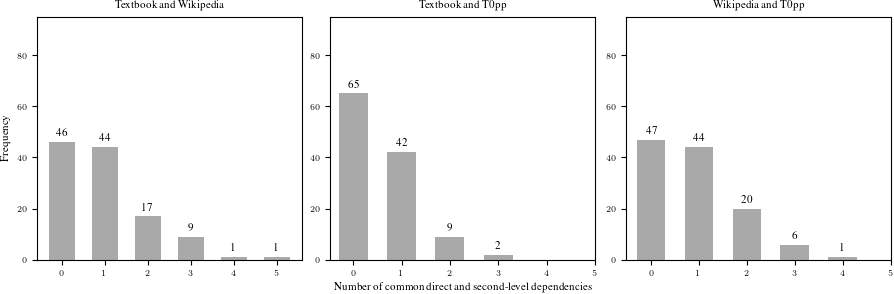

In [85]:
dep_freqs = deps.loc[filter]
dep_freqs = dep_freqs.iloc[:,-3:].apply(pd.Series.value_counts)

figs, ax = plt.subplots(1, 3, figsize=(9,3))

ax[0].set_title("Textbook and Wikipedia")
rects = ax[0].bar(dep_freqs.index,dep_freqs['num_common_tb_wiki2'],width=0.6, color="darkgrey")
ax[0].bar_label(rects, padding=3)
ax[0].set_ylabel('Frequency')
ax[0].set_xticks(dep_freqs.index)
ax[0].set_ylim(0, 95)

ax[1].set_title("Textbook and T0pp")
rects = ax[1].bar(dep_freqs.index,dep_freqs['num_common_tb_llm2'],width=0.6, color="darkgrey")
ax[1].bar_label(rects, padding=3)
ax[1].set_xticks(dep_freqs.index)
ax[1].set_ylim(0, 95)

ax[2].set_title("Wikipedia and T0pp")
rects = ax[2].bar(dep_freqs.index,dep_freqs['num_common_llm_wiki2'],width=0.6, color="darkgrey")
ax[2].bar_label(rects, padding=3)
ax[2].set_xticks(dep_freqs.index)
ax[2].set_ylim(0, 95)

ax[1].set_xlabel('Number of common direct  and second-level dependencies')
plt.show()

In [86]:
figs.savefig("../doc/img/comp_second_deps.pdf", format="pdf")